In [1]:
%load_ext autoreload

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s') # NOTSET, DEBUG, INFO, WARN, ERROR, CRITICAL

from JPAS_DA.data import data_loaders
from JPAS_DA.data import wrapper_data_loaders
from JPAS_DA.models import model_building_tools
from JPAS_DA.training import training_tools
from JPAS_DA.training import save_load_tools
from JPAS_DA.evaluation import evaluation_tools
from JPAS_DA.wrapper_wandb import wrapper_tools
from JPAS_DA.evaluation import wandb_evaluation_tools

import os
import torch
import numpy as np

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from JPAS_DA.utils import plotting_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('default')
plt.close('all')
font, rcnew = plotting_utils.matplotlib_default_config()
mpl.rc('font', **font)
plt.rcParams.update(rcnew)
plt.style.use('tableau-colorblind10')
%matplotlib widget

from JPAS_DA.utils import aux_tools
aux_tools.set_seed(42)

In [2]:
path_wandb_sweep_no_DA = '/home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/SAVED_models/11_wandb_no_DA'
path_wandb_sweep_DA = '/home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/SAVED_models/11_wandb_DA'

2025-05-18 09:16:09,436 - INFO - 🔍 Scanning sweep folders in: /home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/SAVED_models/11_wandb_no_DA
2025-05-18 09:16:09,436 - INFO - 📁 Found 110 sweep directories.
/home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/JPAS_DA/evaluation/wandb_evaluation_tools.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


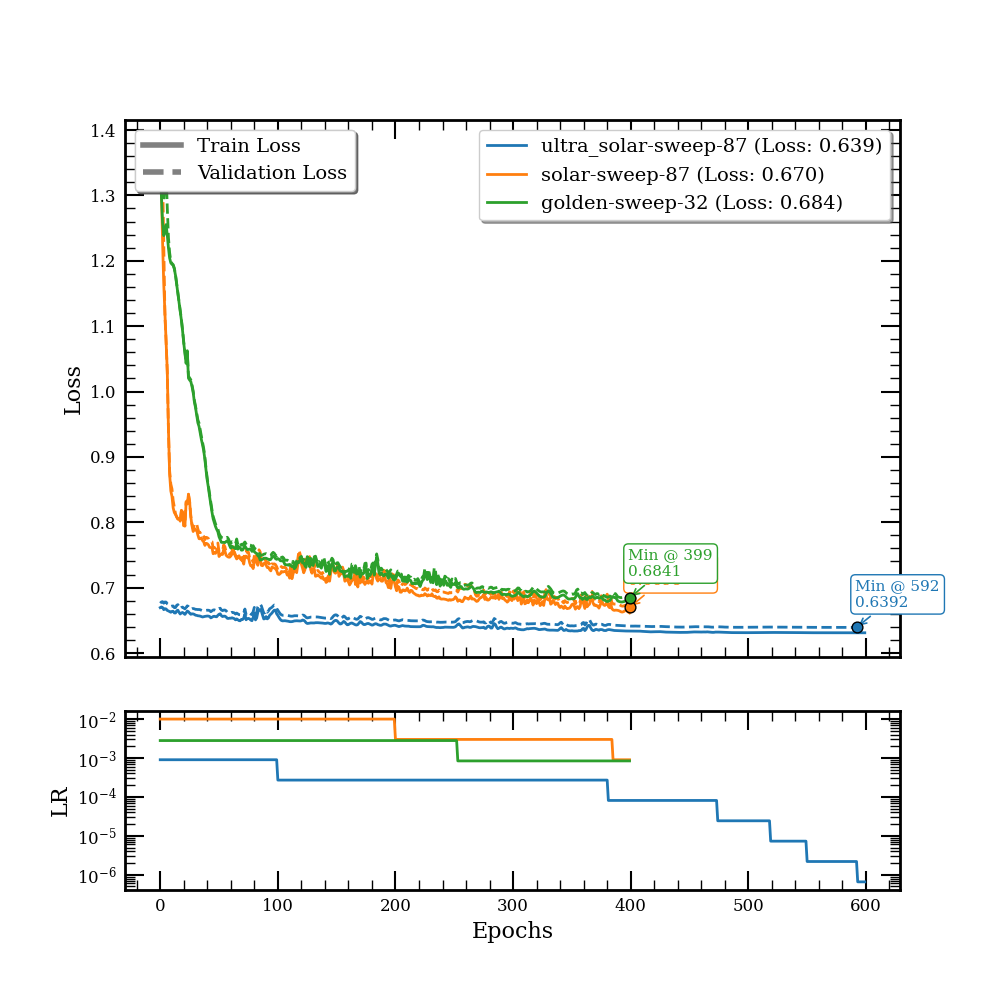

2025-05-18 09:16:09,673 - INFO - ✅ Plotted best runs.
2025-05-18 09:16:09,673 - INFO - 🔍 Scanning sweep folders in: /home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/SAVED_models/11_wandb_DA
2025-05-18 09:16:09,673 - INFO - 📁 Found 10 sweep directories.


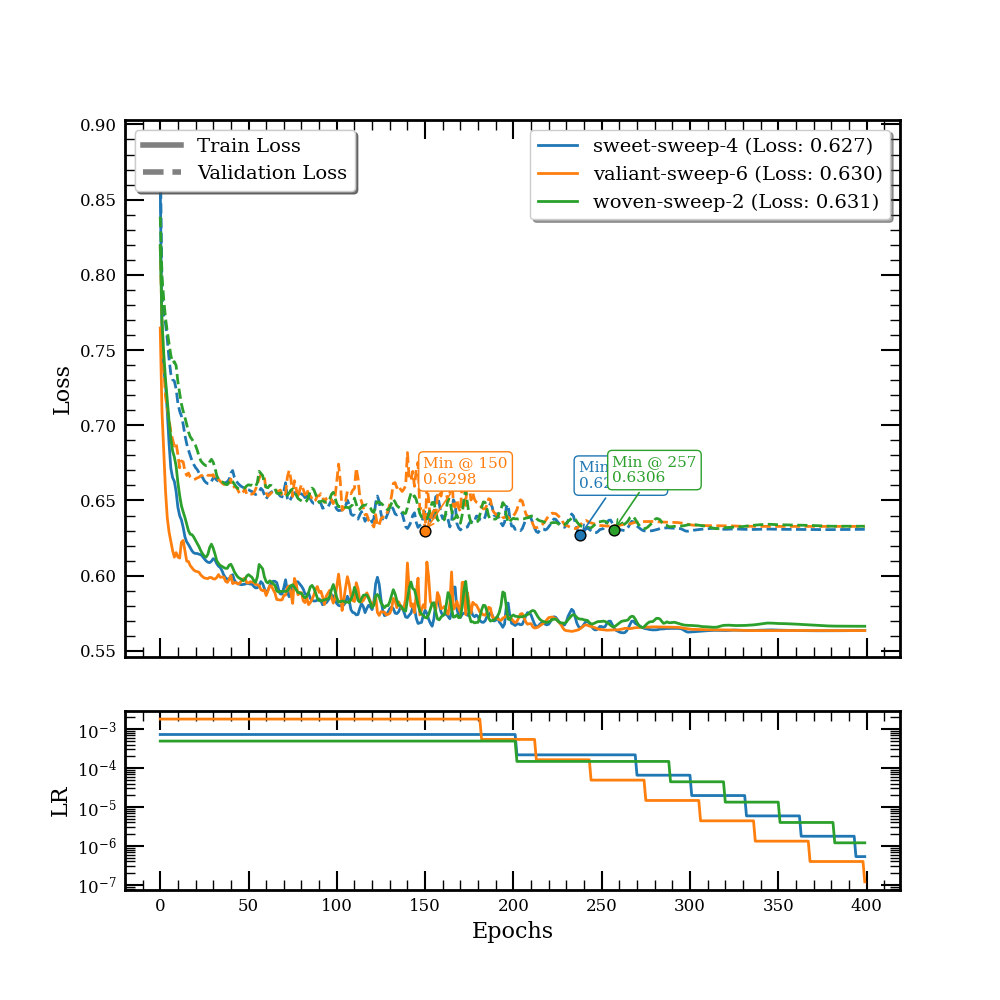

2025-05-18 09:16:09,944 - INFO - ✅ Plotted best runs.


In [3]:
sorted_list_sweep_names_no_DA, sorted_losses_no_DA = wandb_evaluation_tools.load_and_plot_sorted_sweeps(path_wandb_sweep_no_DA, max_runs_to_plot=3)
sorted_list_sweep_names_DA, sorted_losses_DA = wandb_evaluation_tools.load_and_plot_sorted_sweeps(path_wandb_sweep_DA, max_runs_to_plot=3)

In [4]:
path_load_no_DA = os.path.join(path_wandb_sweep_no_DA, sorted_list_sweep_names_no_DA[0])
path_load_DA = os.path.join(path_wandb_sweep_DA, sorted_list_sweep_names_DA[0])

In [5]:
_, model_encoder_no_DA = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_no_DA, "model_encoder.pt"), model_building_tools.create_mlp)
_, model_downstream_no_DA = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_no_DA, "model_downstream.pt"), model_building_tools.create_mlp)

_, model_encoder_DA = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_DA, "model_encoder.pt"), model_building_tools.create_mlp)
_, model_downstream_DA = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_DA, "model_downstream.pt"), model_building_tools.create_mlp)

_ = evaluation_tools.compare_model_parameters(model_downstream_no_DA, model_downstream_DA, rtol=1e-2, atol=1e-2)

✅ All parameters match.


/home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/JPAS_DA/training/save_load_tools.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_che

In [6]:
config_no_DA = wrapper_tools.load_config_file(os.path.join(path_load_no_DA, "config.yaml"))
config_DA = wrapper_tools.load_config_file(os.path.join(path_load_DA, "config.yaml"))

2025-05-18 09:16:11,576 - INFO - 🔍 Checking for config file at: /home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/SAVED_models/11_wandb_no_DA/ultra_solar-sweep-87/config.yaml
2025-05-18 09:16:11,580 - INFO - ✅ Successfully loaded config file: /home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/SAVED_models/11_wandb_no_DA/ultra_solar-sweep-87/config.yaml
2025-05-18 09:16:11,580 - INFO - 🔍 Checking for config file at: /home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/SAVED_models/11_wandb_DA/sweet-sweep-4/config.yaml
2025-05-18 09:16:11,582 - INFO - ✅ Successfully loaded config file: /home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/SAVED_models/11_wandb_DA/sweet-sweep-4/config.yaml


In [7]:
dict_data = config_no_DA["data"]
dict_data_DA = config_DA["data"]

assert isinstance(dict_data, dict) and isinstance(dict_data_DA, dict), "Both inputs must be dictionaries."
assert dict_data == dict_data_DA, f"❌ Dictionaries differ!\nExpected:\n{dict_data}\n\nGot:\n{dict_data_DA}"

In [8]:
means, stds = save_load_tools.load_means_stds(path_load_no_DA)
dict_data["provided_normalization"] = (means, stds)

dset_loaders = wrapper_data_loaders.wrapper_data_loaders(**dict_data)
dset_val_no_DA = dset_loaders['DESI_combined']['val']
dset_val_DA = dset_loaders['JPAS_matched']['val']
dset_test = dset_loaders['JPAS_matched']['test']

2025-05-18 09:16:13,423 - INFO - 📦 Starting full data preparation pipeline...
2025-05-18 09:16:13,423 - INFO - 

1️⃣: Loading datasets from disk...
2025-05-18 09:16:13,423 - INFO - 📥 Starting full dataset loading with `load_dsets()`
2025-05-18 09:16:13,423 - INFO - ├ Loading JPAS datasets...
2025-05-18 09:16:13,423 - INFO - ├─── 📥 Starting JPAS dataset loading...
2025-05-18 09:16:13,424 - INFO - |    ├─── 🔹 Dataset: all (sample 100%)
2025-05-18 09:16:13,466 - INFO - |    |    ✔ CSV loaded: JPAS_DATA_PROPERTIES.csv (shape: (52020, 18))
2025-05-18 09:16:13,477 - INFO - |    |    ✔ NPY loaded: JPAS_DATA_Aper_Cor_3_FLUX+NOISE.npy (obs shape: (52020, 57))
2025-05-18 09:16:13,477 - INFO - ├─── ✅ Finished loading all JPAS datasets.
2025-05-18 09:16:13,479 - INFO - ├ Loading DESI datasets (splitted)...
2025-05-18 09:16:13,479 - INFO - ├─── 📥 Starting DESI dataset loading...
2025-05-18 09:16:13,479 - INFO - |    ├─── 🔹 Dataset: train
2025-05-18 09:16:14,419 - INFO - |    |    ✔ CSV loaded ((108

In [9]:
xx, yy_true = dset_val_no_DA(batch_size=dset_val_no_DA.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_no_DA(xx)
        logits = model_downstream_no_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)

yy_true_val_no_DA = yy_true.cpu().numpy()
features_val_no_DA = features_.cpu().numpy()
yy_pred_P_val_no_DA = yy_pred_P.cpu().numpy()
yy_pred_val_no_DA = np.argmax(yy_pred_P_val_no_DA, axis=1)


xx, yy_true = dset_val_DA(batch_size=dset_val_DA.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_DA(xx)
        logits = model_downstream_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)

yy_true_val_DA = yy_true.cpu().numpy()
features_val_DA = features_.cpu().numpy()
yy_pred_P_val_DA = yy_pred_P.cpu().numpy()
yy_pred_val_DA = np.argmax(yy_pred_P_val_DA, axis=1)


xx, yy_true = dset_test(batch_size=dset_test.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_no_DA(xx)
        logits = model_downstream_no_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)

yy_true_test = yy_true.cpu().numpy()
features_test_no_DA = features_.cpu().numpy()
yy_pred_P_test_no_DA = yy_pred_P.cpu().numpy()
yy_pred_test_no_DA = np.argmax(yy_pred_P_test_no_DA, axis=1)


xx, yy_true = dset_test(batch_size=dset_test.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_DA(xx)
        logits = model_downstream_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)

yy_true_test = yy_true.cpu().numpy()
features_test_DA = features_.cpu().numpy()
yy_pred_P_test_DA = yy_pred_P.cpu().numpy()
yy_pred_test_DA = np.argmax(yy_pred_P_test_DA, axis=1)

In [10]:
n_classes = len(dset_test.class_labels)

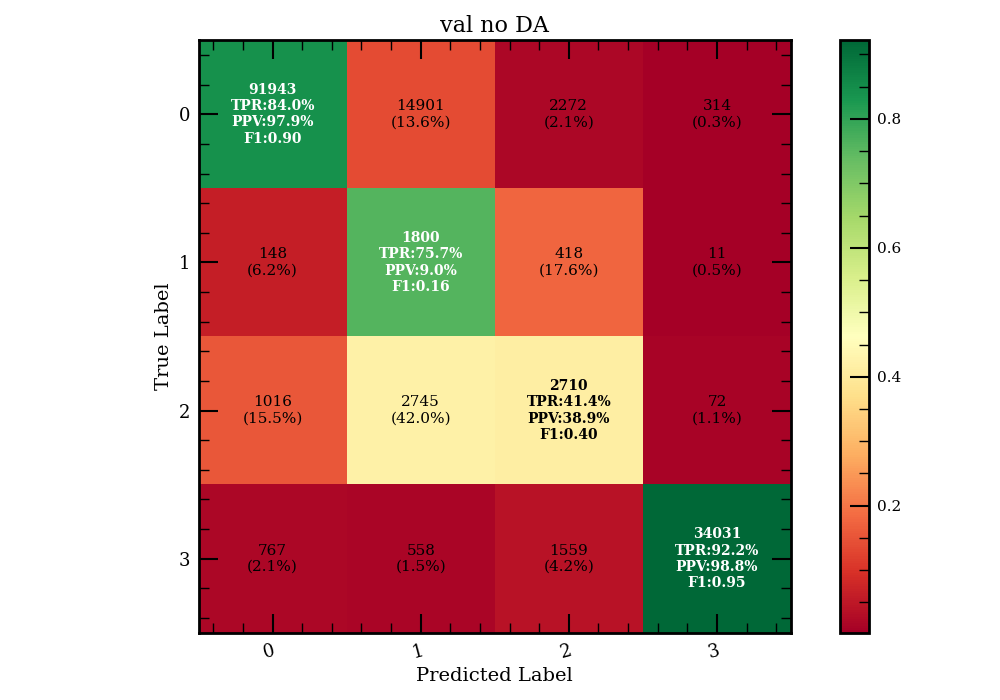

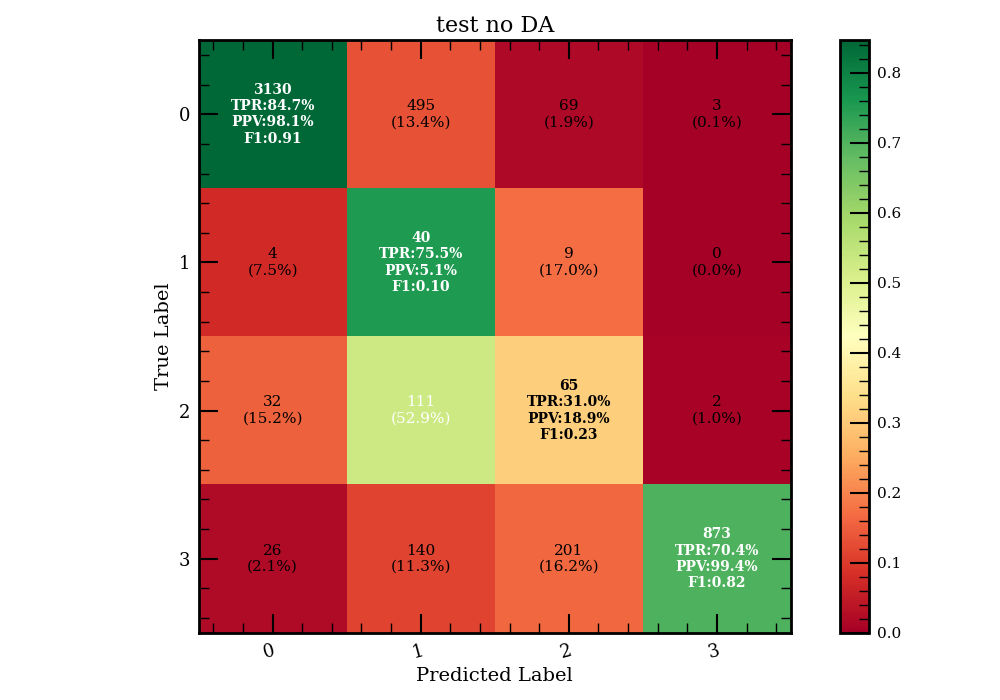

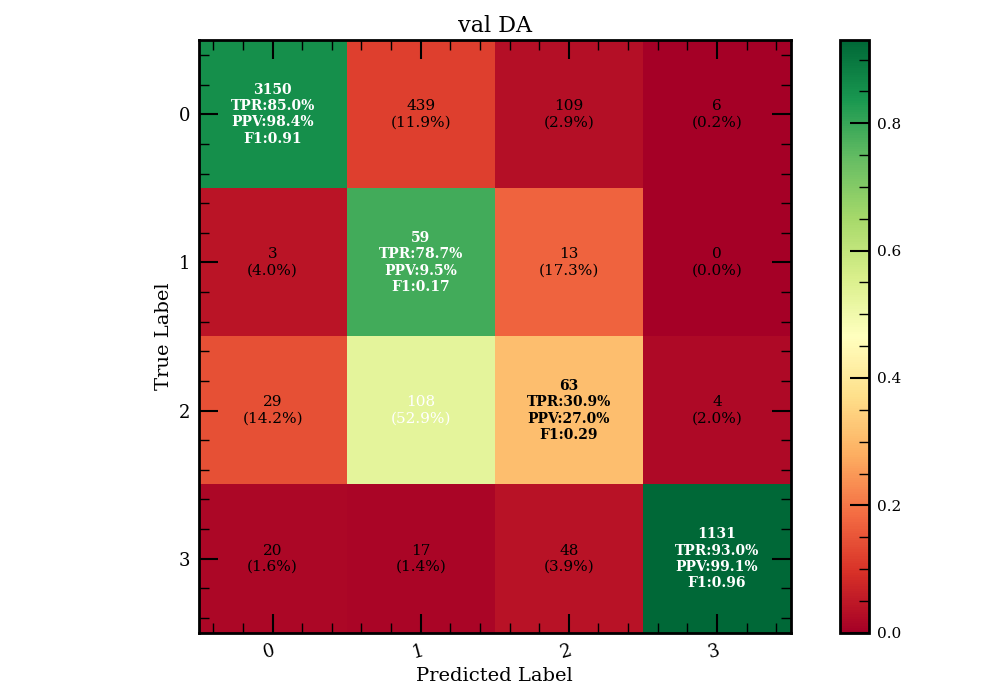

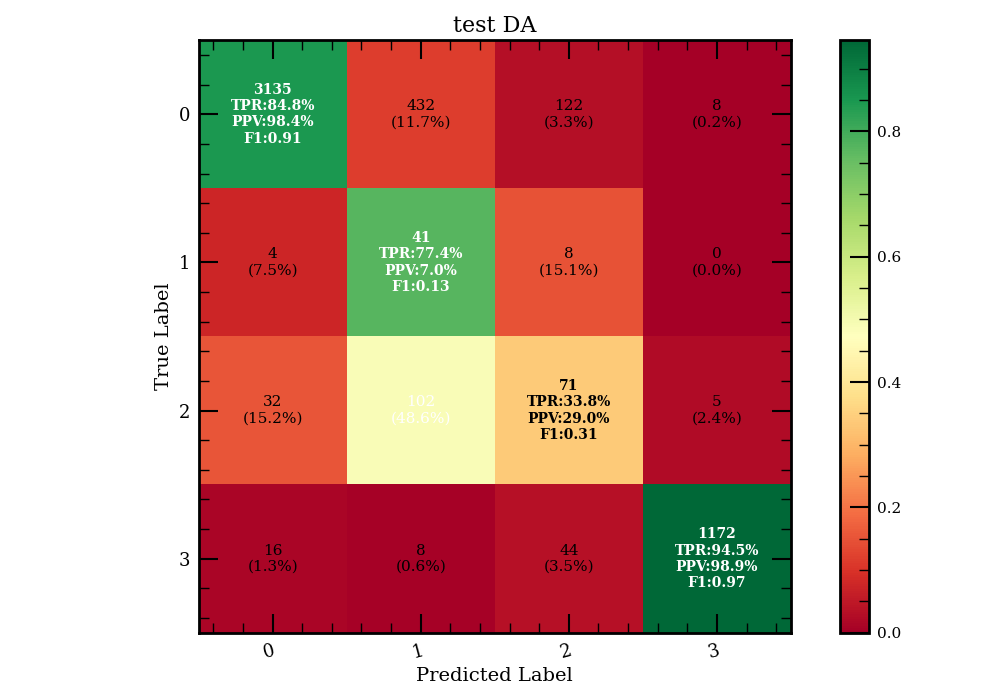

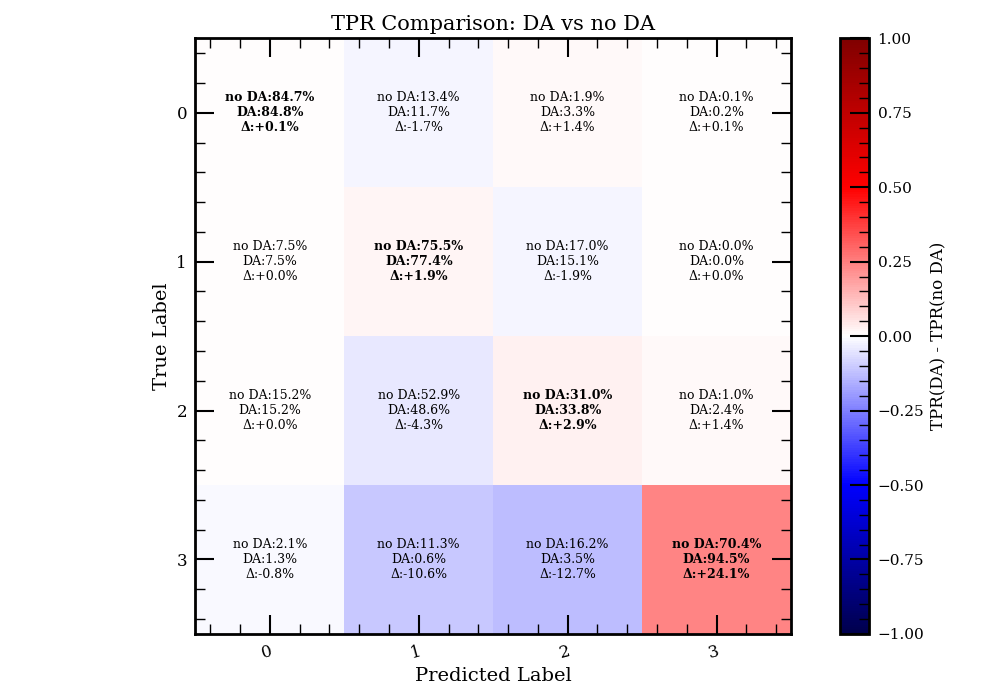

In [11]:
plotting_utils.plot_confusion_matrix(
    yy_true_val_no_DA, yy_pred_P_val_no_DA,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="val no DA"
)

plotting_utils.plot_confusion_matrix(
    yy_true_test, yy_pred_P_test_no_DA,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="test no DA"
)

plotting_utils.plot_confusion_matrix(
    yy_true_val_DA, yy_pred_P_val_DA,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="val DA"
)

plotting_utils.plot_confusion_matrix(
    yy_true_test, yy_pred_P_test_DA,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="test DA"
)

plotting_utils.compare_TPR_confusion_matrices(
    yy_true_test,
    yy_pred_P_test_no_DA,
    yy_true_test,
    yy_pred_P_test_DA,
    class_names=np.arange(n_classes),
    figsize=(10, 7),
    cmap='seismic',
    title='TPR Comparison: DA vs no DA',
    name_1 = "no DA",
    name_2 = "DA"
)


=== no DA vs DA Metrics ===
Metric                     no DA          DA    Δ (DA - no DA)
--------------------------------------------------------------
Accuracy                  0.7900      0.8498            0.0598
Macro F1                  0.5158      0.5796            0.0638
Macro TPR                 0.6537      0.7262            0.0725
Macro Precision           0.5537      0.5832            0.0295
Macro AUROC               0.8505      0.9028            0.0523
ECE                       0.1941      0.1471           -0.0470


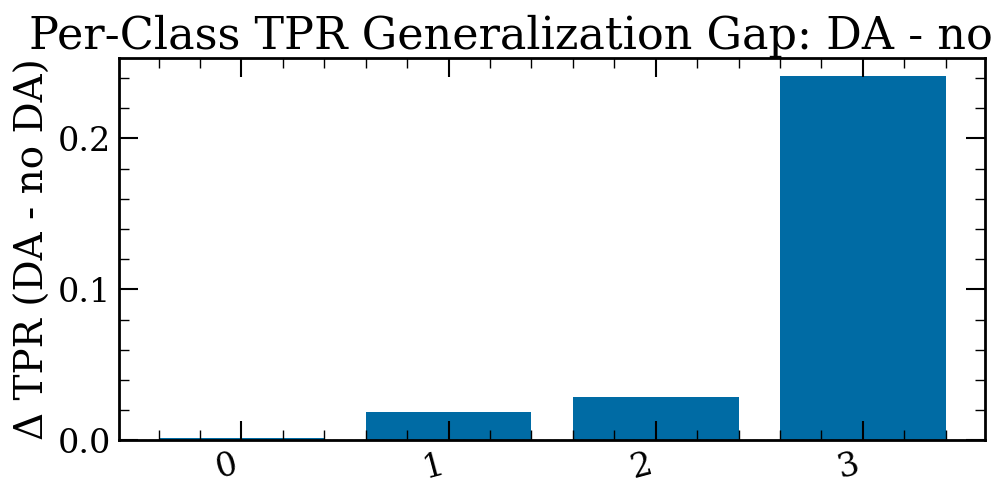

In [12]:
plotting_utils.compare_sets_performance(
    yy_true_test, yy_pred_P_test_no_DA,
    yy_true_test, yy_pred_P_test_DA,
    class_names=np.arange(n_classes),
    name_1="no DA",
    name_2="DA"
)

In [13]:
from sklearn.manifold import TSNE

# === Stack all feature representations together ===
n_val_no_DA = features_val_no_DA.shape[0]
n_val_DA = features_val_DA.shape[0]
n_test_no_DA = features_test_no_DA.shape[0]
n_test_DA = features_test_DA.shape[0]

X_all = np.vstack([
    features_val_no_DA,
    features_val_DA,
    features_test_no_DA,
    features_test_DA
])

# === Perform shared t-SNE projection ===
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42)
X_all_tsne = tsne.fit_transform(X_all)

# === Split back to original domains ===
i0 = 0
i1 = i0 + n_val_no_DA
i2 = i1 + n_val_DA
i3 = i2 + n_test_no_DA
i4 = i3 + n_test_DA

X_val_no_DA_tsne   = X_all_tsne[i0:i1]
X_val_DA_tsne      = X_all_tsne[i1:i2]
X_test_no_DA_tsne  = X_all_tsne[i2:i3]
X_test_DA_tsne     = X_all_tsne[i3:i4]

/tmp/ipykernel_70376/294883300.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


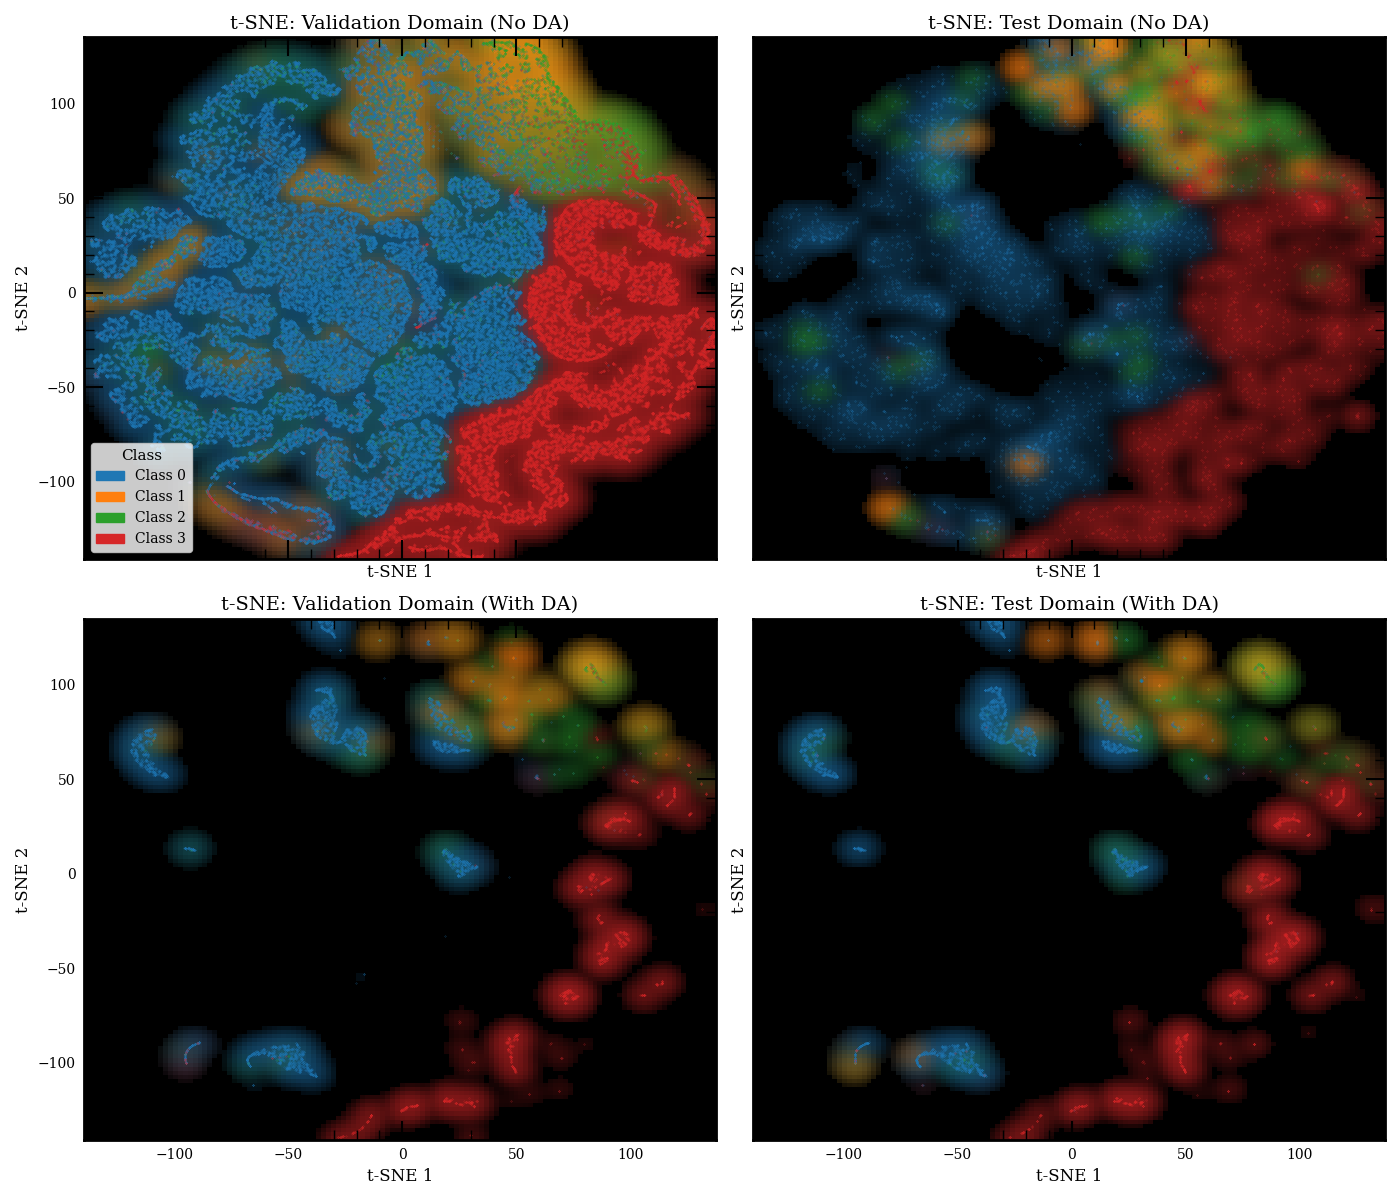

In [14]:
import matplotlib.patches as mpatches
from scipy.stats import binned_statistic_2d
from scipy.ndimage import gaussian_filter

# === Use consistent labels and colors ===
y_all = np.concatenate([yy_true_val_no_DA, yy_true_val_DA, yy_true_test, yy_true_test])
unique_classes = np.unique(y_all)
cmap = plt.cm.get_cmap("tab10")
class_color_dict = {cls: cmap(i) for i, cls in enumerate(unique_classes)}
class_rgb = np.array([class_color_dict[cls][:3] for cls in unique_classes])

# === Class counts and inverse-frequency weights ===
class_counts = dset_test.class_counts
inv_freq_weights = 1 / class_counts
inv_freq_weights = inv_freq_weights / np.sum(inv_freq_weights)
assert len(inv_freq_weights) == len(unique_classes)

# === Datasets to plot ===
datasets = [
    ("Validation Domain (No DA)", X_val_no_DA_tsne, yy_true_val_no_DA),
    ("Test Domain (No DA)",       X_test_no_DA_tsne, yy_true_test),
    ("Validation Domain (With DA)", X_val_DA_tsne, yy_true_val_DA),
    ("Test Domain (With DA)",     X_test_DA_tsne, yy_true_test),
]

# === Create figure and determine bounds ===
fig, axs = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
all_points = np.vstack([X for _, X, _ in datasets])
x_min, x_max = np.min(all_points[:, 0]), np.max(all_points[:, 0])
y_min, y_max = np.min(all_points[:, 1]), np.max(all_points[:, 1])
n_bins = 128
sigma = 2.0

# === Plot each dataset ===
for ax, (title, X_emb, y_labels) in zip(axs.ravel(), datasets):
    ax.set_title(f"t-SNE: {title}", fontsize=14)
    ax.set_xlabel("t-SNE 1", fontsize=12)
    ax.set_ylabel("t-SNE 2", fontsize=12)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.tick_params(labelsize=10)

    # Grid counting per class
    H_class = np.zeros((n_bins, n_bins, len(unique_classes)))
    for i, cls in enumerate(unique_classes):
        idx = y_labels == cls
        if np.sum(idx) == 0:
            continue
        stat, _, _, _ = binned_statistic_2d(
            X_emb[idx, 0], X_emb[idx, 1], None,
            statistic='count', bins=n_bins,
            range=[[x_min, x_max], [y_min, y_max]]
        )
        stat = gaussian_filter(stat.T, sigma=sigma)
        H_class[:, :, i] = stat * inv_freq_weights[i]

        ax.scatter(X_emb[idx, 0], X_emb[idx, 1], color=class_color_dict[cls], label=f"Class {cls}", s=0.05, alpha=0.8)

    # Blend RGB according to class composition
    H_total = np.sum(H_class, axis=2, keepdims=True)
    proportions = np.divide(H_class, H_total, out=np.zeros_like(H_class), where=H_total != 0)
    image_rgb = np.tensordot(proportions, class_rgb, axes=(2, 0))

    # === Improved density modulation ===
    density = H_total.squeeze()
    # === Logarithmic brightness modulation ===
    eps = 1e-3  # to avoid log(0)
    density_log = np.log1p(density / eps)
    panel_max = np.max(density_log)
    if panel_max > 0:
        density_mod = density_log / panel_max
    else:
        density_mod = density_log  # all zeros, just skip scaling
    density_mod[density < eps] = 0  # force very empty bins to black
    image_rgb *= density_mod[..., None]

    ax.imshow(image_rgb, extent=[x_min, x_max, y_min, y_max],
              origin='lower', aspect='auto', interpolation='nearest')

# === Legend ===
legend_elements = [
    mpatches.Patch(color=class_color_dict[cls], label=f"Class {cls}")
    for cls in unique_classes
]
axs[0, 0].legend(handles=legend_elements, title="Class", fontsize=10, title_fontsize=11)

plt.tight_layout()
plt.show()
